# Kernelized Support Vector Machines

Kernelized Support Vector Machines (SVM) are extensions of Linear Models while it allows the construction of more complex (non linear) models.
We can use SVMs for classification (implemented in SVC) and regression (implemented in SVR).

## 1.0 Linear models and nonlinear features

Linear models are very limited in low dimensional spaces. A way to surpass the limitation is to add more features.

Let's first plot a 2d dataset with 2 classes.

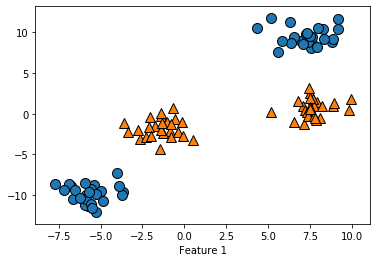

In [2]:
import mglearn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=4, random_state=8)
y = y % 2

mglearn.discrete_scatter(X[:,0], X[:,1], y)
plt.xlabel("Feature 0")
plt.xlabel("Feature 1");

As you can notice, it's not linearly separable. Therefore a linear model will fail.

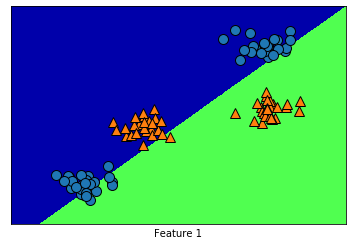

In [16]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC(max_iter=5000).fit(X, y)

mglearn.plots.plot_2d_classification(linear_svm, X)
mglearn.discrete_scatter(X[:,0], X[:,1], y)
plt.xlabel("Feature 0")
plt.xlabel("Feature 1");

Let's augment the data with a new nonlinear feature and plot it in a 3d dimensional plot

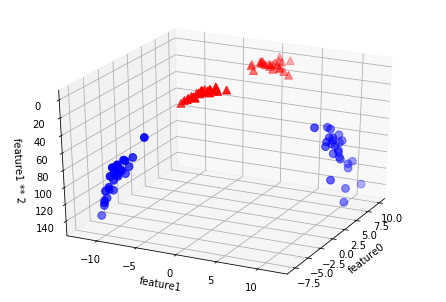

In [20]:
import numpy as np

X_new = np.hstack([X, X[:,1:]**2])

from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()

ax = Axes3D(figure, elev=-152, azim=-26)

mask=y==0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', cmap=mglearn.cm2, s=60)

ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2");

As you can notice, a hyperplane (now) can separate the 2 classes.

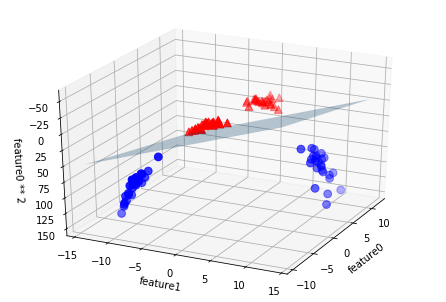

In [22]:
linear_svm_3d = LinearSVC(max_iter=5000).fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

figure = plt.figure()

ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)
XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]

ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', cmap=mglearn.cm2, s=60)

ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature0 ** 2");

As a function of the features, the decision boundary is NOT linear anymore.

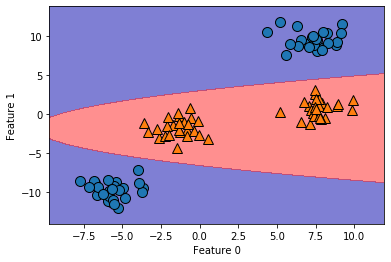

In [26]:
ZZ=YY**2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()], cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

plt.xlabel("Feature 0")
plt.ylabel("Feature 1");

## 2.0 The kernel trick

Adding nonlinear features to our dataset can make linear models much more powerful!!!

The problem is: What feature do I have to add to make it separable?

Luckly there is a math trick that can help us with the problem of learning a classifier in higher-dimensional spaces with out computing the new (very large) representation.

The kernel tricks computes the distance of the data points for the expanded feature representation without actually computing the expansion.

Tehre are two ways to map your data into a higher-dimensional space that are commonly used with SVMs: (1) polynomial kernel, and (2) radial basis functions (RBF) kernel (a.k.a Gaussian Kernal)

(1) computes all possible polynomials up to a certain degree of the original features.
(2) considers all polynomials of all degrees, but the importance of the features decreases with higher degrees.

### 2.1 Understanding SVMs

SVMs learn the importance of each data point in the training phase. Usually, only a subset of the training points matter for defining the decision boundary. For SVMs the ones that lie on the border between classes.
These are called support vectors.

The importance of each support vector is stores in dual_coef_ attribute of SVC. To make a new prediction, the distance to each of the support vectors is measured. The nearest support vector defines the class.

The distance between data poins is measured by the Gaussian Kernel: k_rbf(x_1, x_2) = exp(gamma*||x_1-x_2||^2))

gamma controls the width of the Gaussian Kernel, x_1 and x_2 are the data points and ||...||^2 is the Euclidean distance.

Let's see the SVM applied to a 2d dataset :)

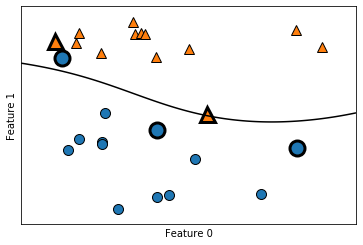

In [30]:
from sklearn.svm import SVC

X,y = mglearn.tools.make_handcrafted_dataset()
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X,y)

mglearn.plots.plot_2d_separator(svm, X, eps=.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

sv = svm.support_vectors_

sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)

plt.xlabel("Feature 0")
plt.ylabel("Feature 1");

SVM produces a very smooth and nonlinear boundary.

### 2.2 Tuning SVM parameters

gamma: controls the width of the Gaussian kernel. It determines the scale of what it means for points to be close together.

C: is the regularization parameter. it limits the importance of each data points.

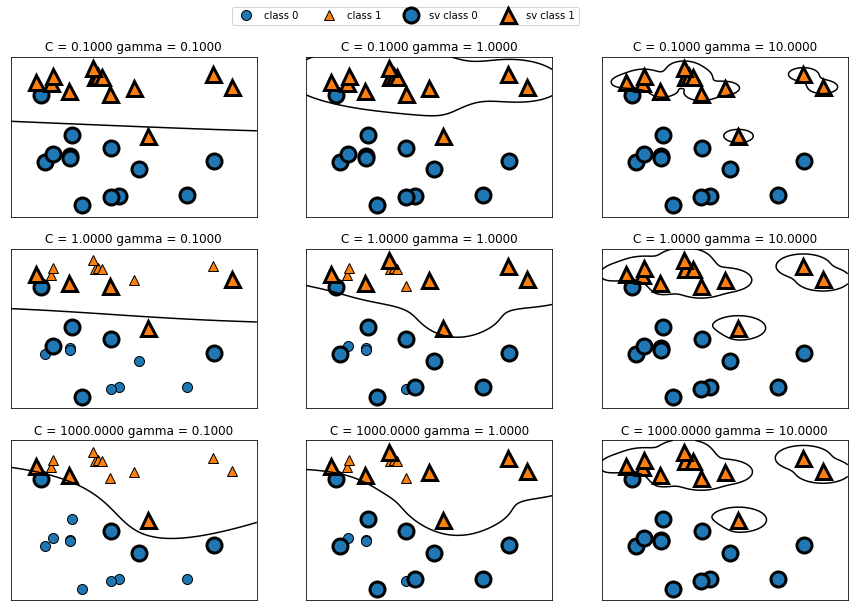

In [32]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)
axes[0, 0].legend(["class 0", "class 1", "sv class 0", "sv class 1"], ncol=4, loc=(.9, 1.2))

A small gamma (large radious) means that more points are considered close by this implies that we'll have very smooth decision boundaries (very low complexity model).

a small C means that the data points have a very limited influence on the decision boundary, that is, a low complexity model.

In [39]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

svc = SVC(kernel='rbf', C=1, gamma=1/X.shape[1])
svc.fit(X_train, y_train)

print("Accuracy on training set: {}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {}".format(svc.score(X_test, y_test)))

Accuracy on training set: 1.0
Accuracy on test set: 0.6293706293706294


SVMs are very sensitive to the parameter values and the scaling of the dataset.

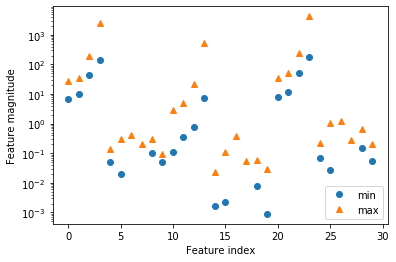

In [41]:
plt.plot(X_train.min(axis=0), 'o', label="min")
plt.plot(X_train.max(axis=0), '^', label="max")
plt.legend(loc=4)
plt.xlabel("Feature index")
plt.ylabel("Feature magnitude")
plt.yscale("log")

An option to tackle this issue is to rescale each feature, so that, it has approx. the same scale.

In [42]:
min_on_training = X_train.min(axis=0)
range_on_training = (X_train - min_on_training).max(axis=0)
X_train_scaled = (X_train - min_on_training)/range_on_training

print("Minimum for each feature\n{}".format(X_train_scaled.min(axis=0)))
print("Maximum for each feature\n {}".format(X_train_scaled.max(axis=0)))

Minimum for each feature
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Maximum for each feature
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [43]:
X_test_scaled = (X_test - min_on_training) / range_on_training

In [61]:
svc = SVC(kernel='rbf', C=1.0, gamma=1/X.shape[1])
svc.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 0.979
Accuracy on test set: 0.972


What a difference!

### 2.3 Strengths, weaknesses, and parameters

SVMs are powerful models and perform well on a variery of datasets, but they don't scale well with the number of data points.

Usually, it requires a careful pre-processing rescaling the dataset and a strong hyperparameter tuning.

Furthermore, SVMs are hard to inspect, therefore it is hard to explain the model to a non-expert.

The important parameters of SVMs are C (regularization parameter) and the parameters of the kernel (ie gamma).